In [41]:
import pandas as pd
import numpy as np

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from ast import literal_eval

import pyLDAvis
import pyLDAvis.gensim

from unidecode import unidecode
from core.plots import plot_topic_recurrences, plot_words_intopic
from core.hyperparams import compute_coherence_values

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Plotting hyperparameter search results

def plot_hprms(values):
    import matplotlib.pyplot as plt
    limit=11; start=2; step=1;
    x = range(start, limit, step)
    plt.plot(x, values, c='k')
    plt.xlabel("Num Topics", fontsize=18)
    plt.axvline(x[np.argmax(values)], linestyle='--', c='r', label='optimal n topics')
    plt.ylabel("Coherence score", fontsize=18)
    plt.title('Topic Modeling LDA', fontsize=18)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Necesidades País

In [59]:
question = 'country' #country or personal
all_needs = pd.read_csv ('data/{}_needs.csv'.format(question))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
def clean_alt_list(list_):
    list_ = str(list_)
    list_ = list_.replace(' ','')
    list_ = list_.replace('[', '')
    list_ = list_.replace(']', '')
    list_ = list_.replace("'", '')
    list_ = list_.split(',')
    return list_

def concat_cols(row):
    skip = ['nan', 'NR', np.nan, 'NaN']
    name = row['name_tokens'] 
    exps = row['exp_tokens']

    if name in skip and exps in skip:
        new_row = np.nan
    if name in skip and exps not in skip:
        new_row = exps
    if name not in skip and exps in skip:
        new_row = name
    if name not in skip and exps not in skip:
        new_row = name+exps
        
    return new_row

In [61]:
all_needs['name_tokens'] = all_needs['name_tokens'].apply(lambda x: clean_alt_list(x))
all_needs['exp_tokens'] = all_needs['exp_tokens'].apply(lambda x: clean_alt_list(x))

In [62]:
all_needs['name_exp'] = all_needs.apply(lambda x: concat_cols(x), 1)

In [63]:
all_needs['name_exp'] = all_needs['name_exp'].apply(lambda x: [xx for xx in x if xx != 'NR'])

In [64]:
needs = all_needs[~all_needs['name_exp'].isna()].copy()

In [65]:
tokens = needs.name_exp.values

In [66]:
%%time
# Diccionario
id2word = corpora.Dictionary(tokens)

# Corpus
texts = tokens

# Frecuencia de términos de cada documento
corpus = [id2word.doc2bow(text) for text in texts]

CPU times: user 2.43 s, sys: 27 ms, total: 2.46 s
Wall time: 2.46 s


In [68]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=tokens, start=8, limit=9, step=1)

max_ix = np.argmax(coherence_values)
plot_hprms(coherence_values)

In [69]:
import os
os.makedirs('models/hp/country', exist_ok=True)
for i, m in enumerate(model_list):
    lda_model.save('models/hp/country/{}.model'.format(i+2))

In [70]:
lda_model = model_list[max_ix] #Best LDA Model
# lda_model = gensim.models.LdaMulticore.load('models/{}_lda.model'.format(question)) #If best model was saved.
plot_words_intopic(lda_model)

In [151]:
# lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=True)
# pyLDAvis.display(lda_display)

In [71]:
def predict_topic(lda_model, corpus, topic_dict):
    output = list(lda_model[corpus])[0]
    topics = sorted(output, key=lambda x:x[1], reverse=True)[0]
    return topic_dict[topics[0]]

In [72]:
### Mediante conocimiento experto, los topicos quedaron agrupados:
topic_dict = {     
     0:'Adultos Mayores',
     1:'Educación',
     2:'Igualdad',
     3:'Seguridad',
     4:'Previsión social',
     5:'Salud',
     6:'Trabajo',
     7:'Previsión social',
} 

In [73]:
%%time
preds = []
last_topic = []
ix=0
for need in all_needs.exp_tokens:
    try:
        pred = predict_topic(lda_model, corpus[ix], topic_dict)
        preds.append(pred)
    except Exception as e:
        last_topic.append(e)
    ix+=1

In [74]:
all_needs['macro'] = preds

In [75]:
# Verificar si el nombre coincide con el macro cuando este hace 
# referencia a un topico
topic_unicode = [unidecode(str(x)).lower() for x in topic_dict.values()]
new_preds = []
for index, row in all_needs.iterrows():
    if row['name'] in topic_unicode:
        new_preds.append(topic_dict[topic_unicode.index(row['name'])])
    else:
        new_preds.append(row['macro'])

In [76]:
all_needs['macro'] = new_preds

In [77]:
all_needs_save = all_needs.iloc[:, :-1]

In [78]:
all_needs_save.to_csv('data/{}_needs.csv'.format(question), index=False)
lda_model.save('models/{}_lda.model'.format(question))

## Necesidades Personales

In [49]:
question = 'personal' #country or personal

all_needs = pd.read_csv ('data/{}_needs.csv'.format(question), low_memory=False)

all_needs['name_tokens'] = all_needs['name_tokens'].apply(lambda x: clean_alt_list(x))
all_needs['exp_tokens'] = all_needs['exp_tokens'].apply(lambda x: clean_alt_list(x))
all_needs['name_exp'] = all_needs.apply(lambda x: concat_cols(x), 1)
all_needs['name_exp'] = all_needs['name_exp'].apply(lambda x: [xx for xx in x if xx != 'NR'])
needs = all_needs[~all_needs['name_exp'].isna()].copy()
tokens = needs.name_exp.values

In [50]:
%%time
id2word = corpora.Dictionary(tokens)
texts = tokens
corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=tokens, start=8, limit=9, step=1)

max_ix = np.argmax(coherence_values)
# plot_hprms(coherence_values)

CPU times: user 3min 55s, sys: 17.3 s, total: 4min 12s
Wall time: 4min 3s


In [51]:
import os
os.makedirs('models/hp/personal', exist_ok=True)
for i, m in enumerate(model_list):
    lda_model.save('models/hp/personal/{}.model'.format(i+2))

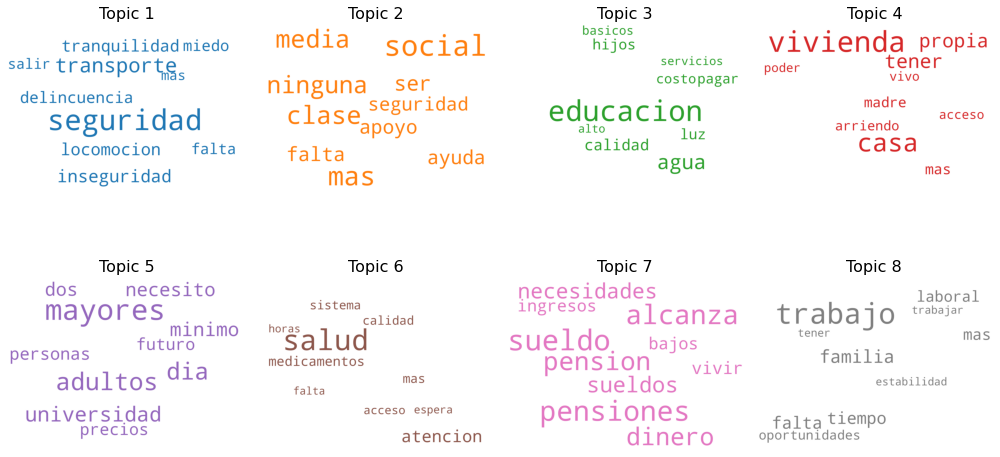

In [52]:
question = 'personal'
lda_model =  model_list[max_ix] 
# lda_model = gensim.models.LdaMulticore.load('models/hp/personal/6.model'.format(question))

plot_words_intopic(lda_model)

In [23]:
# lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False) #Topicos ordenados por recurrencia de palabras.
# pyLDAvis.display(lda_display)

In [53]:
topic_dict = {
    0:'Transporte',
    1:'Seguridad',
    2:'Trabajo',
    3:'Educación',
    4:'Previsión social',
    5:'Salud',
    6:'Vivienda',
    7:'costo de vida',
} 

In [54]:
%%time
preds = []
last_topic = []
ix=0
for need in all_needs.exp_tokens:
    try:
        pred = predict_topic(lda_model, corpus[ix], topic_dict)
        preds.append(pred)
    except Exception as e:
        last_topic.append(e)
    ix+=1

CPU times: user 47 s, sys: 6.23 ms, total: 47 s
Wall time: 47 s


In [55]:
last_topic

[]

In [56]:
all_needs['macro'] = preds
# Verificar si el nombre coincide con el macro cuando este hace 
# referencia a un topico
topic_unicode = [unidecode(str(x)).lower() for x in topic_dict.values()]
new_preds = []
for index, row in all_needs.iterrows():
    if row['name'] in topic_unicode:
        new_preds.append(topic_dict[topic_unicode.index(row['name'])])
    else:
        new_preds.append(row['macro'])

In [57]:
all_needs['macro'] = new_preds
all_needs_save = all_needs.iloc[:, :-1]
all_needs_save

,id,diag_id,ind_id,name,name_tokens,exp,exp_tokens,macro,priority,is_online
0,0,enc_u_4602780640112847056,NaN,mucho cobro luz y agua,"[cobro, luz, agua]",subio excesivamente la luz y el agua,"[subio, excesivamente, luz, agua]",Trabajo,0,False
1,1,enc_u_4602778880117363308,NaN,agua potable,"[agua, potable]",aun no tenemos agua potable en el sector rural,"[aun, agua, potable, sector, rural]",Trabajo,1,False
2,2,enc_u_4602777200118509403,NaN,necesidad en alimentos,"[necesidad, alimentos]",no tiene ayuda municipal \nla falta de titulos...,"[ayuda, municipal, falta, titulos, terreno]",Trabajo,2,False
3,3,enc_u_4602651983012551467,NaN,tranquilidad,[tranquilidad],la situacion actual ha generado alteracion en ...,"[situacion, actual, generado, alteracion, conv...",Transporte,4,False
4,4,enc_u_4602650820112130336,NaN,salud,[salud],tengo que siempre estar esperando para que ...,"[siempre, esperando, atiendan, espera, operaci...",Salud,0,False
...,...,...,...,...,...,...,...,...,...,...
91601,91601,NaN,06238d0ecda4b66ace2ec74f99df1602,paz,[paz],NaN,[NR],Seguridad,3,True
91602,91602,NaN,cf9c6ae918788181e12eb8bc1e7bfd56,seguridad,[seguridad],saber que no sufriremos violencia (ya sea por ...,"[saber, sufriremos, violencia, violentistas, f...",Seguridad,3,True
91603,91603,NaN,badc99f5376f83d04011d72b16f5ed9a,salud,[salud],alto costo en general en la salud y medicamentos,"[alto, costo, general, salud, medicamentos]",Salud,3,True
91604,91604,NaN,2eac9b65b2b1ec5d134d6b45c83315fe,futuro,[futuro],incierto futuro para chile,"[incierto, futuro, chile]",Previsión social,3,True


In [58]:
all_needs.to_csv('out/personal_needs.csv', index=False)
lda_model.save('models/personal_lda.model')